In [1]:
import os
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision.transforms as T
from torchvision.utils import make_grid

In [2]:
print('Torch version : ',torch.__version__)

DATASET_PATH = '/kaggle/input/animefacedataset/images'
DATA_DIR = '/kaggle/input/animefacedataset'

Torch version :  2.8.0+cu126


Total images : 63565


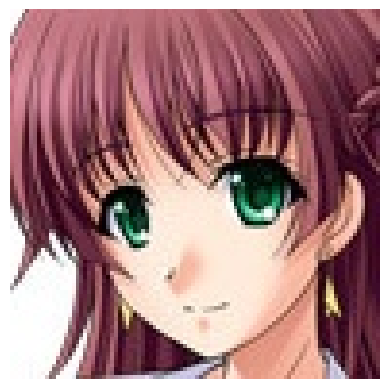

In [3]:
def show_random_image_from_dataset(PATH = '/kaggle/input/animefacedataset/images'):
    image_files = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.lower().endswith('.jpg')]
    if image_files is None:
        print('Image dir not found!')

    print(f'Total images : {len(image_files)}')
    img_path = random.choice(image_files)
    img = mpimg.imread(img_path)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_random_image_from_dataset()

In [4]:
IMAGE_SIZE = 64
BATCH_SIZE = 128 

transformation_v2 = v2.Compose([
    v2.RandomResizedCrop(size = (224, 224), antialias = True),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transformation_T = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(*stats)             # [-1, 1] for all pixels
])

In [5]:
train_ds = ImageFolder(DATA_DIR, transform = transformation_T)

# (num_workers = 3 )
# [each worker independently fetches data from the dataset] -> [collates it into a batch of BATCH_SIZE] -> [places it into a shared memory queue for the main process to retrieve]
# data for next step preloaded on CPU (while GPU is busy w current training batch)
train_dl = DataLoader(
    train_ds, 
    BATCH_SIZE, 
    shuffle = True, 
    num_workers = 3, 
    pin_memory = True
)

In [6]:
# dataiter = iter(train_dl)
# images, labels = next(dataiter)

# # Print the shape (torch.Size is an alias for .shape)
# print(f'Shape of images batch: {images.shape}')              # (BATCH_SIZE, C, H, W)
# print(f'Shape of labels batch: {labels.shape}')

In [7]:
def denormalization(image_tensors, stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))):
    z = image_tensors
    std, mean = stats[1][0], stats[0][0]
    denorm_tensor = ((z * std) + mean)       # range_old[-1, 1] --> range_new[0, 1] (ND)
    return denorm_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


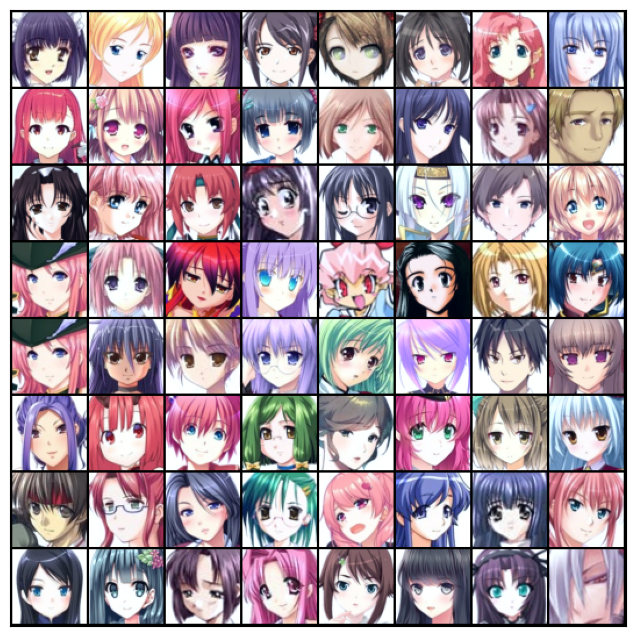

In [8]:
def show_images(images, nmax = 64):
    fig, axs = plt.subplots(figsize = (8, 8))
    denormalized = denormalization(images.detach()[:nmax]) # torch.Size([64, 3, 64, 64])
    grid = make_grid(denormalized)                         # [3, 530, 530] (C, H, W) (post make_grid)
    grid = grid.permute(1, 2, 0)                           # [530, 530, 3] (H, W, C) (fixing order)  
    axs.set_xticks([]); axs.set_yticks([]);
    axs.imshow(grid)
    
def show_batch(data_loader, nmax = 64):
    for image, _ in data_loader:
        show_images(image)
        break    

show_batch(train_dl)

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")                # pointer to GPU
    else:
        return torch.device("CPU")

def move_to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [move_to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [10]:
# for wrapping train_dl (whenever a batch is pulled out -> it is passed on to the device)
class DeviceDataLoader():
    def __init__(self, dl, device):
        """Consider and init the training dataloader and default device"""
        self.dl = dl 
        self.device = device 

    def __iter__(self):                          
        """yield a batch of data after moving it to device"""
        for batch in self.dl:
            yield move_to_device(batch, self.device)

    def __len__(self):
        """returns number of batches"""
        return len(self.dl)

In [11]:
DEVICE = get_default_device()
print(f'Available : {DEVICE}')

Available : cuda


In [12]:
train_dl = DeviceDataLoader(train_dl, DEVICE)

### DISCRIMINATOR (real/fake image classification)

In [13]:
import torch.nn as nn

In [14]:
"""LEARNING_TREND : As spatial data propagates ahead through succeeding layers -> channels double, dim halves"""
discriminator = nn.Sequential(
    # I/P : 3 x 64 x 64  --> O/P : 64 x 32 x 32               
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 64, eps = 1e-05, momentum=0.1),
    nn.LeakyReLU(negative_slope = 0.2, inplace = True),

    # I/P : 64 x 32 x 32  --> O/P : 128 x 16 x 16
    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 128, eps = 1e-05, momentum=0.1),
    nn.LeakyReLU(negative_slope = 0.2, inplace = True),
    
    # I/P : 128 x 16 x 16  --> O/P : 256 x 8 x 8
    nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 256, eps = 1e-05, momentum=0.1),
    nn.LeakyReLU(negative_slope = 0.2, inplace = True),   
    
    # I/P : 256 x 8 x 8  --> O/P : 512 x 4 x 4
    nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 512, eps = 1e-05, momentum=0.1),
    nn.LeakyReLU(negative_slope = 0.2, inplace = True),

    # I/P : 512 x 4 x 4  --> O/P : 1 x 1 x 1  (padding is 0 so a kernel of size 4x4 on an image of size 4x4)
    nn.Conv2d(in_channels = 512, out_channels = 1, kernel_size = 4, stride = 1, padding = 0, bias = False),

    # vector obtained of size 1 [1, 1]
    nn.Flatten(),

    # for probability (1 / 1 + e^-x)  [REAL / FAKE : 2 classes] (if > 2 classes : Softmax)
    nn.Sigmoid()
)

In [15]:
discriminator = move_to_device(discriminator, DEVICE)

### GENERATOR (latent vector/matrix -> anime face image)

In [16]:
latent_vector_size = 128

In [17]:
"""LEARNING_TREND : As latent vector batches propagate ahead through succeeding layers -> channels halves , dims double"""
generator = nn.Sequential(
    # I/P : 128 x 1 x 1  --> O/P : 512 x 4 x 4
    nn.ConvTranspose2d(in_channels = latent_vector_size, out_channels = 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(num_features = 512, eps = 1e-05, momentum=0.1),
    nn.ReLU(inplace = True),              # max(x, 0)

    # I/P : 512 x 4 x 4  --> O/P : 256 x 8 x 8
    nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 256, eps = 1e-05, momentum=0.1),
    nn.ReLU(inplace = True),     

    # I/P : 256 x 8 x 8  --> O/P : 128 x 16 x 16
    nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 128, eps = 1e-05, momentum=0.1),
    nn.ReLU(inplace = True), 

    # I/P : 128 x 16 x 16 --> O/P : 64 x 32 x 32
    nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 64, eps = 1e-05, momentum=0.1),
    nn.ReLU(inplace = True), 

    # I/P : 64 x 32 x 32 --> O/P : 3 x 64 x 64
    nn.ConvTranspose2d(in_channels = 64, out_channels = 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()  # features range reduced to [-1, 1] (images with pixel values in this range)
)

torch.Size([128, 3, 64, 64])


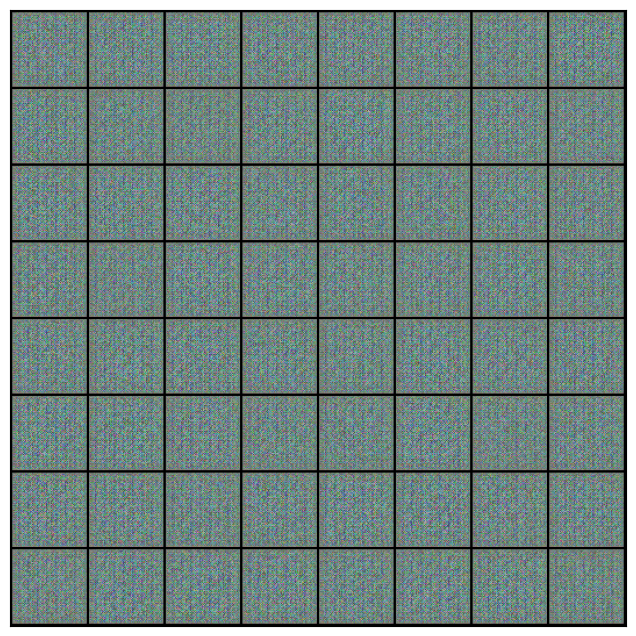

In [18]:
random_test_data = torch.randn(BATCH_SIZE, latent_vector_size, 1, 1)
fake_images = generator(random_test_data)
print(fake_images.shape)

show_images(fake_images)

In [19]:
generator = move_to_device(generator, DEVICE)